In [1]:
import sys, os
PROJECT_ROOT = r"D:\bhermosi\chestxsim-project" 
SRC = os.path.join(PROJECT_ROOT, "src")
if SRC not in sys.path:
    sys.path.insert(0, SRC)

# Reconstruction Module — Usage Guide 

This notebook introduces the **reconstruction module** in ChestXSim and demonstrates how to recosntruct a volume from Digital Chest Tomosynthesis (DCT) projections.  
It shows how to:

- from Polychromatic projections vs Monocrhomatic projections 
- using tradional algorithm FDK and iterative SART
- interpolate original ct to reconstructed tomosynthesis volume 


## Overview

The **reconstruction module** follows the same design philosophy as the projection module.  
Each reconstruction algorithm is implemented as a **step class** that operates on a `volumeData` object and automatically records its parameters in the `metadata`. These require a configured **operator** initialized from a system geometry instance (e.g., `TomoGeometry` for DCT). 


### Operator Recap

The reconstruction step uses the same **operator** interface (`opt`) as the projection module, providing a unified API for forward and backward operations:

- `project(volume3d, voxel_size)` → generates projections `(W, H, Angles)`  
- `backproject(projs, reco_dim, reco_vx_size)` → performs backprojection or full reconstruction `(W, H, D)`

The **`Astra_OP`** class serves as the **abstract base wrapper** for ASTRA within ChestXSim, defining the core methods for initializing geometry, allocating ASTRA projectors, and managing GPU execution.

The **`Astra_Tomo`** subclass provides the **concrete DCT implementation**, configuring ASTRA’s CUDA-based 3D cone-beam geometry:

- **Forward projection:** `FP3D_CUDA`  
- **Backprojection:** `BP3D_CUDA`


### Available Reconstruction Steps

>Unlike the preprocessing or projection modules, the reconstruction module focuses solely on the **reconstruction algorithms** themselves. Any additional post-processing can be implemented as separate steps following the typical caller interface design. 


| Step class | Algorithm | Description |
|-------------|------------|--------------|
| **`BackProject`** | Direct Backprojection | Simple backprojection from raw projections. Useful for testing geometry setup. |
| **`FDK`** | Filtered Backprojection (Feldkamp–Davis–Kress) | Classical analytical cone-beam reconstruction. Includes ramp filtering. |
| **`SART`** | Simultaneous Algebraic Reconstruction Technique | Iterative reconstruction. |

### Analytical Reconstruction - FDK 
The **`FDK`** step performs cone-beam filtered backprojection and supports several configuration options that control reconstruction size and voxel resolution.

**Reconstruction Parameter Variants**
| Parameter              | Description                                                                                                                       |
| ---------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **`match_input=True`** | Uses the input metadata (`original_shape`, `extension_mm`, etc.) to automatically restore the original volume physical size. |
| **`reco_vx`**          | Manually specify voxel size `(sx, sy, sz)` in mm.                                                                                 |
| **`reco_dim_px`**      | Specify reconstruction dimensions in pixels `(nx, ny, nz)`.                                                                       |
| **`reco_dim_mm`**      | Specify target physical size in millimeters, or use `"fov"` to match the system’s geometric field of view (FOV).                  |



GPU detected: Using CuPy with 1 device(s), current device: 0
(1072, 1072, 61, 1)


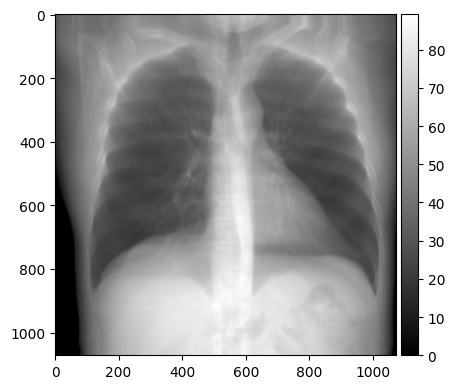

In [2]:
from chestxsim.core import TomoGeometry
from chestxsim.io import RawReader
from chestxsim.wrappers.astra import Astra_Tomo
from chestxsim.utility import plot
from chestxsim.core.device import xp
from chestxsim.reconstruction.steps import FDK


# --- Load 3D projections 
proj_case_folder =  r"D:\bhermosi\chestxsim-project\examples\volumes\NoisyProjections\NODULO_S18_S20"
reader = RawReader()
projs = reader.read(proj_case_folder)
print(projs.volume.shape)
plot(projs.volume[:,:,30,0].get().T)

**Rebuild Geometry from Projection Metadata**

You can either construct the geometry explicitly (as shown earlier) *or* recreate the **exact same geometry used during projection** from metadata.  


In [3]:
md = projs.metadata

# --- Recreate geometry used during projection ---
geo = TomoGeometry.from_dict(md.find("geometry"))
print("Detector size (px):", geo.detector_size)
print("Number of views   :", geo.nstep + 1)   # nstep=60 → 61 views
print("Step per view (mm):", geo.step)

# Operator with the same geometry
opt = Astra_Tomo(geometry=geo)

Detector size (px): [4288, 4288]
Number of views   : 61
Step per view (mm): 16.077


**Recover the  Original Physical Volume Size**

When `match_input=True`, the reconstruction step restores the **original physical dimensions** of the patient volume (in millimeters), based on metadata recorded during preprocessing.
This reconstructs the volume with voxel_size = (1.25, 5.00, 1.25), typical for a DCT system.

In [4]:
md = projs.metadata
ct_vx = md.find("ct_orig_vx")
ct_dim_px = md.find("ct_orig_shape")

ct_dim_mm = [int(xp.ceil(px * vx)) for px, vx in zip(ct_dim_px, ct_vx)]
print("Original CT size (mm):", ct_dim_mm)

Original CT size (mm): [431, 431, 345]


mm (430.08, 430.08, 545.0)
reco_dim px (344, 86, 436)
80 80
FDK shape: (344, 86, 276, 1)


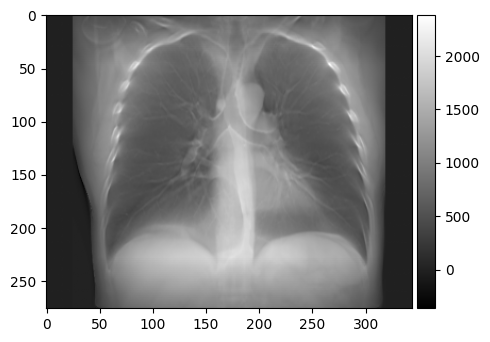

In [5]:
fdk_match = FDK(
    opt=opt,
    match_input=True,          
    reco_vx=(1.25, 5.00, 1.25),
    filter_type="ramp",
    axis=1,
    padding=True
)

reco_match = fdk_match(projs)
print("FDK shape:", reco_match.volume.shape)
plot(reco_match.volume.get()[:, reco_match.volume.shape[1]//2, :, 0].T)  

**Manual Reconstruction Size (pixels or mm)**

Manually control either voxel size and pixel dimensions, or the physical size in mm.

mm None
reco_dim px (344, 86, 300)
FDK (manual px) shape: (344, 86, 300, 1)
mm (430.08, 430.08, 545.0)
reco_dim px (344, 86, 436)
FDK (manual mm) shape: (344, 86, 436, 1)


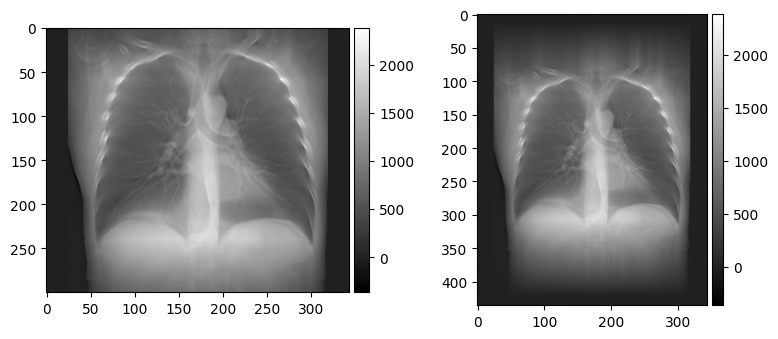

In [6]:
# A) Fix voxel size + pixel dimensions
fdk_manual_px = FDK(
    opt=opt,
    match_input=False,
    reco_vx=(1.25, 5.00, 1.25),      # mm per voxel
    reco_dim_px=(344, 86, 300),      # Nx, Ny, Nz
    filter_type="ramp",
    axis=1,
    padding=True
)

reco_manual_px = fdk_manual_px(projs)
print("FDK (manual px) shape:", reco_manual_px.volume.shape)

# B) Fix physical dimensions directly (mm)
fdk_manual_mm = FDK(
    opt=opt,
    match_input=False,
    reco_dim_mm=(430.08, 430.08, 545.0),  # (mm_x, mm_y, mm_z)
    reco_vx=(1.25, 5.00, 1.25),
    filter_type="ramp",
    axis=1,
    padding=True
)

reco_manual_mm = fdk_manual_mm(projs)
print("FDK (manual mm) shape:", reco_manual_mm.volume.shape)

plot(reco_manual_px.volume.get()[:, reco_manual_px.volume.shape[1]//2, :, 0].T,
     reco_manual_mm.volume.get()[:, reco_manual_mm.volume.shape[1]//2, :, 0].T
     )  


**FOV-based Reeconstruction (fit to system FOV)**

Use the system Field of View (FOV) from geometry to define the target physical size in mm.  The **Field of View (FOV)** defines the **physical region** of the object that can be fully covered by the X-ray beam given the acquisition geometry.  

In [7]:
fov_mm = geo.fov() 
print("System FOV (mm):", fov_mm)

System FOV (mm): [417.5, 835.18, 417.5]


mm [417.5, 835.18, 417.5]
reco_dim px (334, 167, 334)
FDK (FOV) shape: (334, 167, 334, 1)


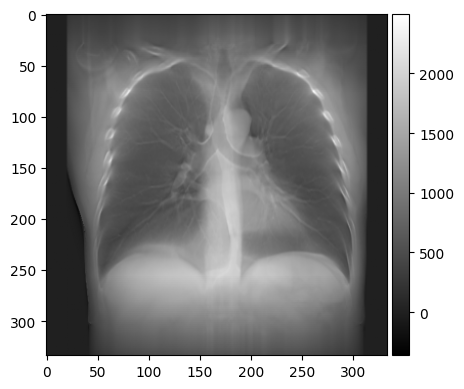

In [8]:
fdk_fov = FDK(
    opt=opt,
    match_input=False,
    reco_dim_mm=fov_mm,        # <- fit reconstruction to the system FOV
    reco_vx=(1.25, 5.00, 1.25),
    filter_type="ramp",
    axis=1,
    padding=True
)

reco_fov = fdk_fov(projs)
print("FDK (FOV) shape:", reco_fov.volume.shape)
plot(reco_fov.volume.get()[:, reco_fov.volume.shape[1]//2, :, 0].T)

> **Note:**  This image clearly illustrates the importance of **extending the volume** during preprocessing. Without proper extension, regions outside the original CT bounds are treated as **air**, leading to missing anatomy within the reconstructed **Field of View (FOV)**.

### Iterative Reconstruction - SART

### Interpolation of CT to Match Reconstructed DCT volumes 


After reconstruction, you may need to **resample the original CT volume** so that it matches the **voxel size** and **dimensions** of the reconstructed DCT data.  
The `Interpolator` step provides this functionality. This step internally performs 3D interpolation using SciPy’s `RegularGridInterpolator`.


In [58]:
from chestxsim.io import DicomReader 
from chestxsim.utility import Interpolator
from chestxsim.preprocessing import AirCropper

# READ CT (atetnuation volume)
dicom_folder = r"D:\bhermosi\chestxsim-project\inputs\NODULO\S18\S20"
reader = DicomReader(convert_to_HU=True, clip_values=(-1024.0, 3000.0))
ct_hu= reader.read(dicom_folder)

# RESAMPLE 
interpolate = Interpolator(target_voxel_size = (1.25, 5.00, 1.25),
                           target_size = (344, 86, 276),
                        )
ct_intep = interpolate(ct_hu)


Original shape: (512, 512, 276)
Resampled shape: (344, 86, 276)


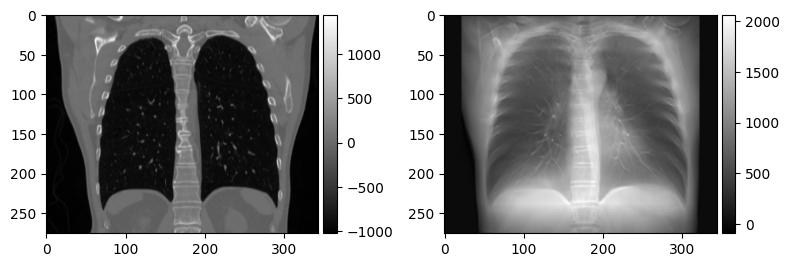

In [63]:
i= 50
plot(ct_intep.volume[:,i,:].T, reco_match.volume.get()[:,i,:,0].T )

In [ ]:
# guardar las dos como img y revisar esto 
# es necesario hacer el crop al ct inicial sin preprocersado ¿?
# segun como esta montada la funcion para interpolar diria que no